# Import all the modules

In [91]:
import cv2
import os, glob
import numpy as np
import tensorflow as tf
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt

from skimage.transform import resize
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from skimage import io
from patchify import patchify, unpatchify
from keras import backend as K
from tensorflow.keras.utils import to_categorical

In [92]:
# Check GPU avalability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError("GPU device not found")
print(f"Found GPU at: {device_name}")

Found GPU at: /device:GPU:0


2022-06-08 15:39:01.213194: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 15:39:01.213523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 15:39:01.213609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 15:39:01.213812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 15:39:01.213901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [93]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])
    except RuntimeError as e:
        print(e)

# Define Hyperparameters and Globals

In [94]:
# Input hyperparameters
NUM_CLASSES = 3
BATCH_SIZE = 1
INPUT_SIZE = (128,128,64)
LABEL_MAP = {0: 'Background', 1: 'temporal_artery', 2: "facial_artery"}

# Model hyperparameters
LR = 0.0001
optimizer = keras.optimizers.Adam(LR)

DATA_DIR = '/media/trojan/evo/3D-CT-Artery-Segmentation/data_64_groups'
train_dir = os.path.join(DATA_DIR, 'train')
train_vol_dir = os.path.join(train_dir, 'images')
train_mask_dir = os.path.join(train_dir, 'labels')
val_dir = os.path.join(DATA_DIR, 'val')
val_vol_dir = os.path.join(val_dir, 'images')
val_mask_dir = os.path.join(val_dir, 'labels')

# Utility Functions

In [95]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """
    Normalize the volume
    Change value range from -1000-400 to 0-1
    """
    min_val = -1000
    max_val = 400
    volume[volume < min_val] = min_val
    volume[volume > max_val] = max_val
    volume = (volume - min_val) / (max_val - min_val)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize volumes to fixed size"""  
    img = resize(img, INPUT_SIZE, order=0)
    return img

def process_scan(path, mode):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    if mode == 'scan':
        volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

def set_mask_cmap(img):
    color_dict = {'Background': 'black','temporal_artery': 'green','facial_artery': 'red'}
    if 1 in img:
        custom_cmap = matplotlib.colors.ListedColormap([color_dict['Background'], 
                                                        color_dict['temporal_artery']])
    elif 2 in img:
        custom_cmap = matplotlib.colors.ListedColormap([color_dict['Background'], 
                                                        color_dict['facial_artery']])
    elif 1 in img and 2 in img:
        custom_cmap = matplotlib.colors.ListedColormap([color_dict['Background'], 
                                                        color_dict['temporal_artery'], 
                                                        color_dict['facial_artery']])
    else:
        custom_cmap = matplotlib.colors.ListedColormap(color_dict['Background'])
    return custom_cmap

# Define Model

In [111]:
# Building an encoder-decoder 3D UNet architecture

# Defining convolutional block
def conv_block(_input, num_filters):
    x = layers.Conv3D(num_filters, 3, padding='same')(_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv3D(num_filters, 3 ,padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    return x

# Encoder block
def encoder_block(_input, num_filters):
    x = conv_block(_input, num_filters)
    p = layers.MaxPooling3D((2,2,2))(x)
    return x, p

# Decoder block
def decoder_block(_input, skip_features, num_filters):
    x = layers.Conv3DTranspose(num_filters, (2,2,2), strides=2, padding='same')(_input)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# Build UNet using blocks
def build_unet(input_shape, num_classes):
    inputs = layers.Input(input_shape)
    
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    b1 = conv_block(p4, 1024)
    
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    if num_classes == 1:
        activation = 'sigmoid'  # Binary case
    else:
        activation = 'softmax'  # Categorical case
        
    outputs = layers.Conv3D(num_classes, 1, padding='same', activation=activation)(d4)
    print(activation)
    
    model = Model(inputs, outputs, name='UNet-3D')
    return model

In [97]:
# model = build_unet((128,128,128,1), num_classes=NUM_CLASSES)

In [98]:
# print(model.summary())

In [99]:
# print(model.input_shape)
# print(model.output_shape)

In input `3` represents RGB while in output `3` represent number of classes.

# Define Custom Generator

In [118]:
"""
Custom data generator to work with nifti files.
We will load data as well as apply preprocessing here.
"""

# Load and process volume
def load_volumes(vol_dir, vol_list):
    volumes = []
    for i, vol_name in enumerate(vol_list):
        if (vol_name.split('.')[1] == 'nii'):
            volume = process_scan(os.path.join(vol_dir, vol_name), mode='scan')
            volumes.append(volume)
            #volume_patches = patchify(volume, PATCH_SIZE, step=12)
            # Reshape to (n_patches,x,y,z)
            #volume_reshape = np.reshape(volume_patches, (-1, volume_patches.shape[3],volume_patches.shape[4],volume_patches.shape[5]))
            #volumes.append(volume_reshape)
    volumes = np.array(volumes)

    return volumes

# Load and process mask
def load_masks(mask_dir, mask_list):
    masks = []
    for i, mask_name in enumerate(mask_list):
        if (mask_name.split('.')[1] == 'nii'):
            mask = process_scan(os.path.join(mask_dir, mask_name), mode='mask')
            mask = np.round(mask)
            mask[mask==3] = 2  # Set extra label to 2 (facial)
            masks.append(mask)
            #mask_patches = patchify(mask, PATCH_SIZE, step=12)
            #mask_reshape = np.reshape(mask_patches, (-1, mask_patches.shape[3],mask_patches.shape[4],mask_patches.shape[5]))
            #masks.append(mask_reshape)
    masks = np.array(masks)
    
    return masks


def DataLoader(vol_dir, mask_dir, batch_size):
    vol_list = sorted(os.listdir(vol_dir))
    mask_list = sorted(os.listdir(mask_dir))
    L = len(vol_list)
    print("Total volumes: ", L)
    
    while True:  # Keras needs it to be infinite
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = (min(batch_end, L))
            
            X = load_volumes(vol_dir, vol_list[batch_start:limit])
            Y = load_masks(mask_dir, mask_list[batch_start:limit])
            X = np.expand_dims(X, axis=4)
            Y = np.expand_dims(Y, axis=4)
            Y = to_categorical(Y, num_classes=NUM_CLASSES)
            
            yield(X, Y)
                  
            batch_start += batch_size
            batch_end += batch_size

In [119]:
# # Test the generator

# import random

# batch_size = 1

# train_vol_datagen = DataLoader(train_vol_dir, train_mask_dir, batch_size)
# volumes, masks = train_vol_datagen.__next__()

# print(volumes.shape)
# print(masks.shape)

In [120]:
# print(np.unique(masks[0], return_counts=True))

In [121]:
# print(masks[0].shape)

In [122]:
# vol_num = random.randint(0, volumes.shape[0]-1)
# test_vol = volumes[vol_num]
# test_mask = masks[vol_num]
# test_mask = test_mask.astype('int')
# print(test_vol.shape)

# num_slice = 62 #random.randint(0, test_mask.shape[2])
# plt.figure(figsize=(12,8))

# plt.subplot(121)
# plt.imshow(np.rot90(test_vol[:,:,num_slice]), cmap='gray')
# plt.title("Image")
# plt.subplot(122)
# plt.imshow(np.rot90(test_mask[:,:,num_slice]), cmap='gray')
# plt.title("Mask")

# Traning pipeline

In [123]:
train_datagen = DataLoader(train_vol_dir, train_mask_dir, BATCH_SIZE)
val_datagen = DataLoader(val_vol_dir, val_mask_dir, BATCH_SIZE)
train_vol, train_mask = train_datagen.__next__()
val_vol, val_mask = val_datagen.__next__()

Total volumes:  461
Total volumes:  121


In [124]:
print(train_vol.shape)
print(train_mask.shape)

(1, 128, 128, 64, 1)
(1, 128, 128, 64, 3)


(128, 128, 64, 1)


Text(0.5, 1.0, 'Mask')

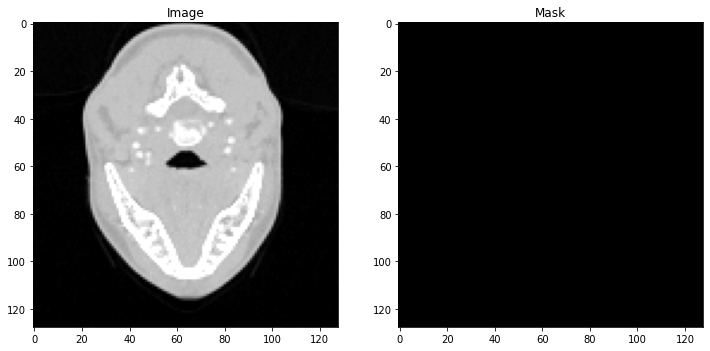

In [125]:
import random

vol_num = random.randint(0, train_vol.shape[0]-1)
test_vol = train_vol[vol_num]
test_mask = train_mask[vol_num]
test_mask = test_mask.astype('int')
print(test_vol.shape)

num_slice = 62 #random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12,8))

plt.subplot(121)
plt.imshow(np.rot90(test_vol[:,:,num_slice]), cmap='gray')
plt.title("Image")
plt.subplot(122)
plt.imshow(np.rot90(test_mask[:,:,num_slice]), cmap='gray')
plt.title("Mask")

# Define metrics

In [126]:
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [127]:
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

In [128]:
# # Sanity check for volume normalization and mask values
# print(train_vol[0].min(), train_vol[0].max())
# print(np.unique(train_mask[0]))

In [129]:
# train_vol = np.expand_dims(train_mask, axis=4)
# train_mask = np.expand_dims(train_mask, axis=4)

In [130]:
# print(train_vol.shape)
# print(train_mask.shape)

In [131]:
# # Convert masks to categorical
# train_mask = to_categorical(train_mask, num_classes=NUM_CLASSES)
# val_mask = to_categorical(val_mask, num_classes=NUM_CLASSES)
# print(train_mask.shape)

In [132]:
# # Loss function and coefficients to be used during the training
# def dice_coefficient(y_true, y_pred):
#     smoothing_factor = 1
#     flat_y_true = K.flatten(y_true)
#     flat_y_pred = K.flatten(y_pred)
#     return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

# def dice_coefficient_loss(y_true, y_pred):
#     return 1 - dice_coefficient(y_true, y_pred)

In [133]:
# Build the model
model = build_unet(INPUT_SIZE + (1,), num_classes=NUM_CLASSES)
#model = build_unet(PATCH_SIZE + (1,), num_classes=NUM_CLASSES)

softmax


In [134]:
model.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)#['accuracy', dice_coefficient])
#model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])#['accuracy', dice_coefficient])
print(model.summary())

Model: "UNet-3D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d_38 (Conv3D)             (None, 128, 128, 64  1792        ['input_3[0][0]']                
                                , 64)                                                             
                                                                                                  
 batch_normalization_36 (BatchN  (None, 128, 128, 64  256        ['conv3d_38[0][0]']              
 ormalization)                  , 64)                                                       

In [135]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 64, 1)
(None, 128, 128, 64, 3)


In [136]:
steps_per_epoch = len(os.listdir(train_vol_dir))//BATCH_SIZE
val_steps_per_epoch = len(os.listdir(val_vol_dir))//BATCH_SIZE
print(steps_per_epoch)
print(val_steps_per_epoch)

461
121


In [137]:
# Define callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
checkpoint = ModelCheckpoint('./model/keras/best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [138]:
# Fit the model
history = model.fit(train_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=5,
                    verbose=1,
                    validation_data=val_datagen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[checkpoint, es])

Epoch 1/5
461/461 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.9884 - iou_score: 0.3274
Epoch 00001: val_loss improved from inf to 0.68071, saving model to ./model/keras/best_model.h5
461/461 [==============================] - 195s 421ms/step - loss: 0.6955 - accuracy: 0.9884 - iou_score: 0.3274 - val_loss: 0.6807 - val_accuracy: 0.9996 - val_iou_score: 0.3332
Epoch 2/5
461/461 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.9996 - iou_score: 0.3332
Epoch 00002: val_loss improved from 0.68071 to 0.67147, saving model to ./model/keras/best_model.h5
461/461 [==============================] - 196s 426ms/step - loss: 0.6743 - accuracy: 0.9996 - iou_score: 0.3332 - val_loss: 0.6715 - val_accuracy: 0.9996 - val_iou_score: 0.3360
Epoch 3/5
 51/461 [==>...........................] - ETA: 2:38 - loss: 0.6714 - accuracy: 0.9994 - iou_score: 0.3332

KeyboardInterrupt: 

In [ ]:
# Plot the trainign and validation Dice and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coefficient']
val_acc = history.history['val_dice_coefficient']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'y', label='Training Dice')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

# Prediction

In [139]:
from keras.metrics import MeanIoU
batch_size = 1

In [140]:
test_datagen = DataLoader(val_vol_dir, val_mask_dir, batch_size)
test_image_batch, test_mask_batch = test_datagen.__next__()
print(test_image_batch.shape)
print(test_mask_batch.shape)

Total volumes:  121
(1, 128, 128, 64, 1)
(1, 128, 128, 64, 3)


In [141]:
from keras.models import load_model
model = load_model('./model/keras/best_model.h5', compile=False)

In [142]:
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)

In [143]:
test_pred_batch = model.predict(test_image_batch)

In [144]:
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

In [145]:
n_classes = 3
iou_keras = MeanIoU(num_classes=n_classes)
iou_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", iou_keras.result().numpy())

Mean IoU = 0.33317724


In [187]:
# Load volume and predict
val_dir = os.path.join(DATA_DIR, 'val')
val_vol_dir = os.path.join(val_dir, 'images')
val_mask_dir = os.path.join(val_dir, 'labels')

vol_name = '11_4.nii.gz'
test_img = process_scan(os.path.join(val_vol_dir, vol_name), mode='scan')
test_mask = process_scan(os.path.join(val_mask_dir, vol_name), mode='mask')

test_img = np.expand_dims(test_img, axis=3)
test_mask = np.expand_dims(test_mask, axis=3)

test_mask_argmax=np.argmax(test_mask, axis=3)

In [188]:
print(test_img.shape)
print(test_mask.shape)

(128, 128, 64, 1)
(128, 128, 64, 1)


In [204]:
unique = np.unique(test_mask, return_counts=True)
print(unique)

(array([0., 1.]), array([1048453,     123]))


In [189]:
test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

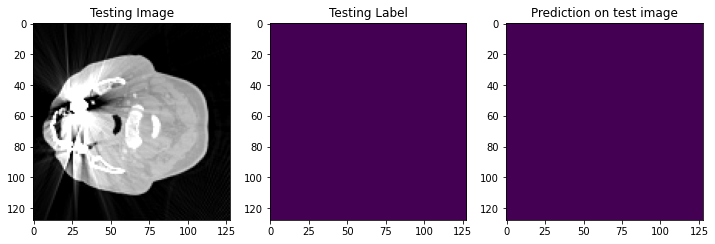

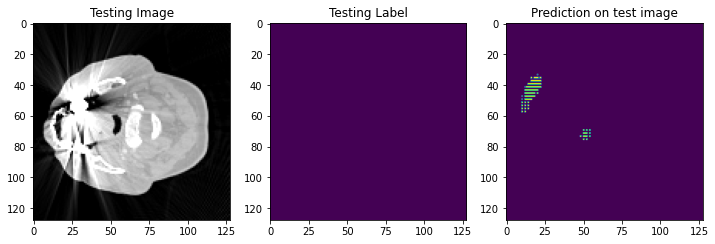

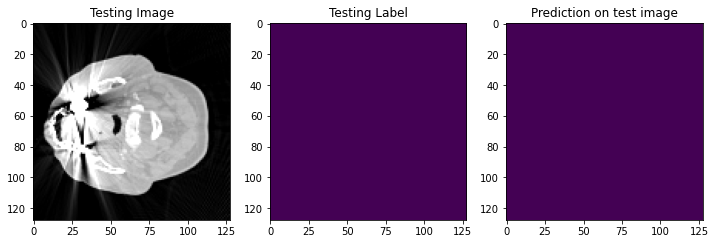

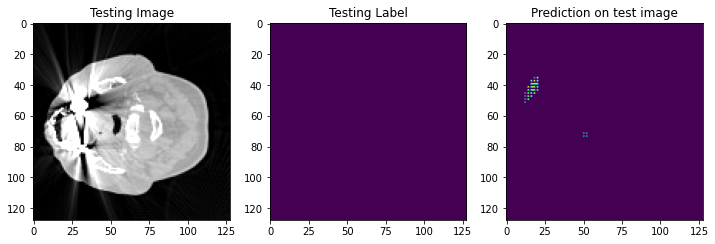

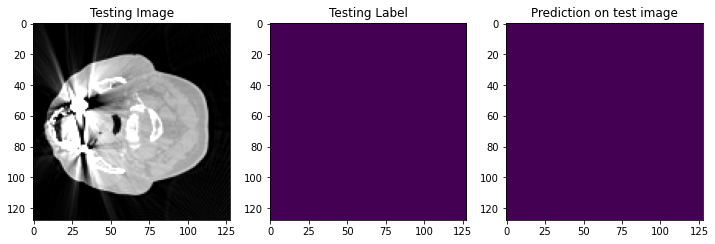

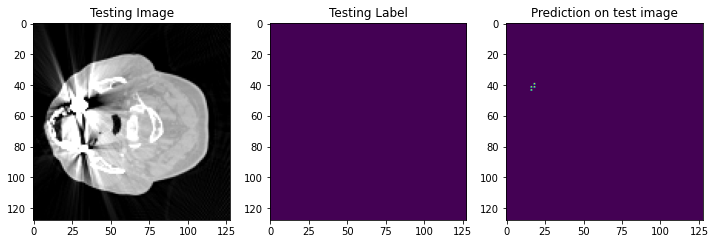

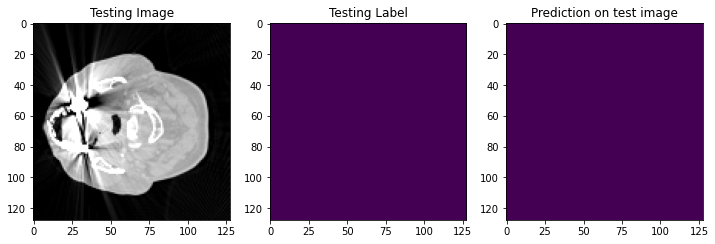

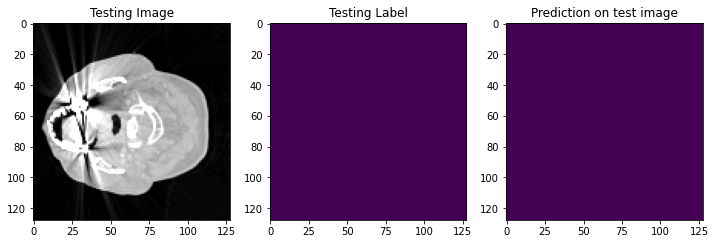

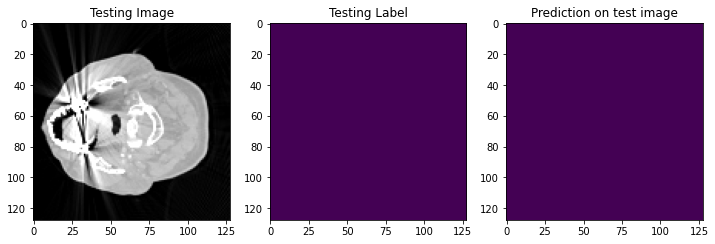

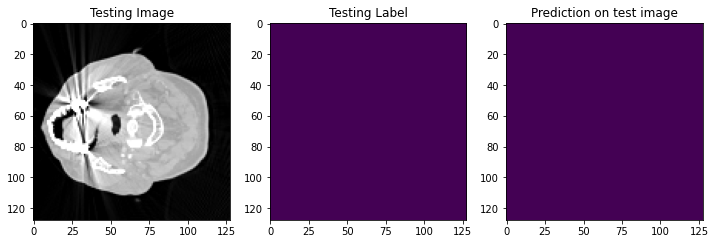

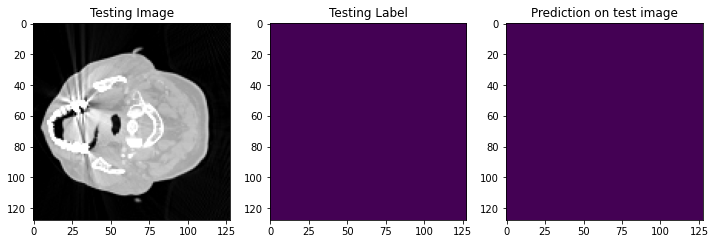

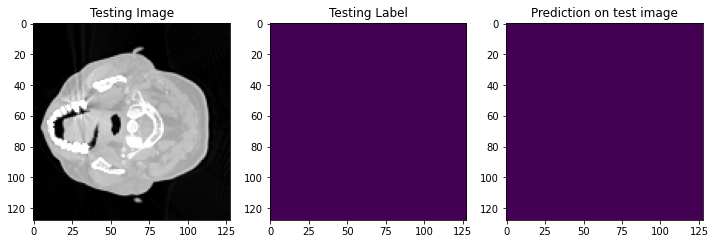

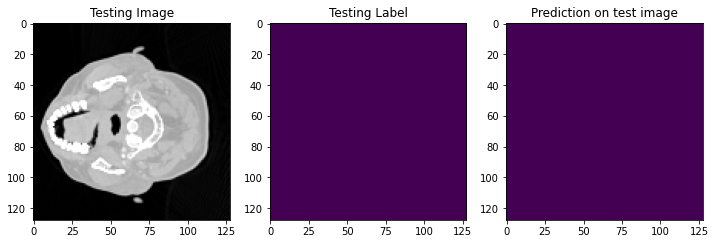

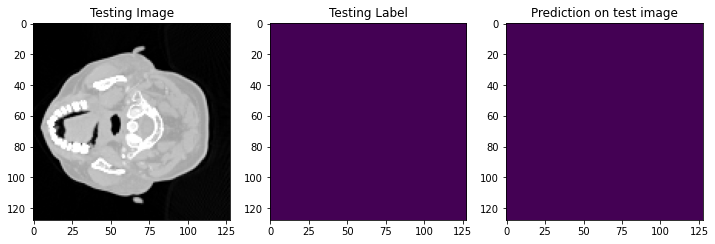

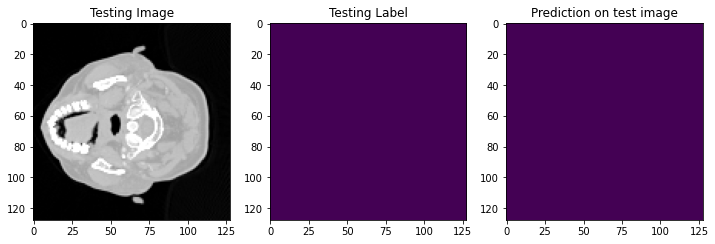

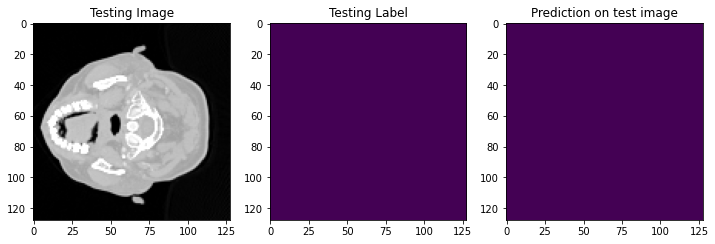

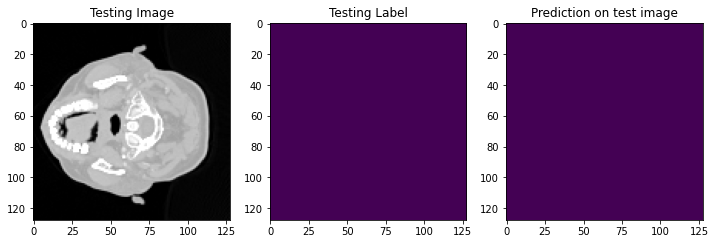

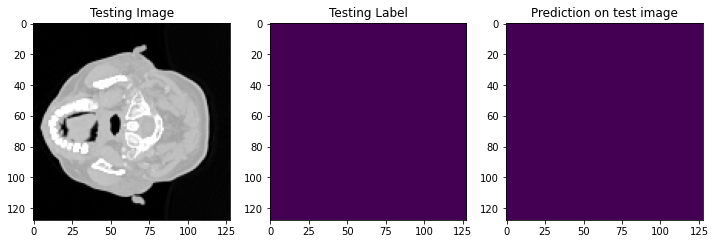

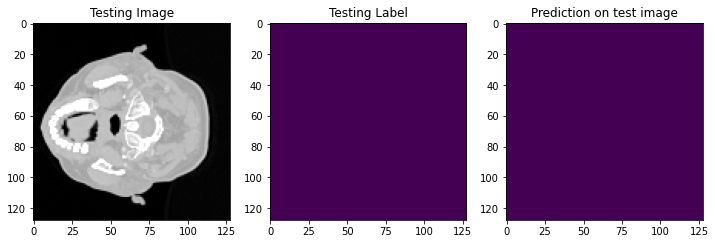

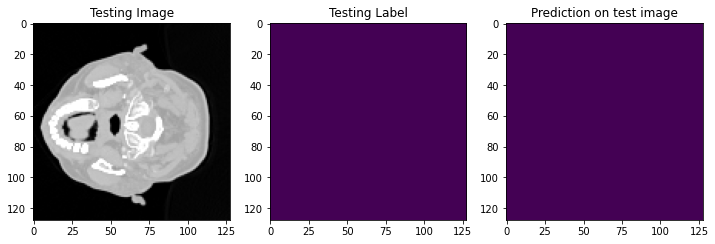

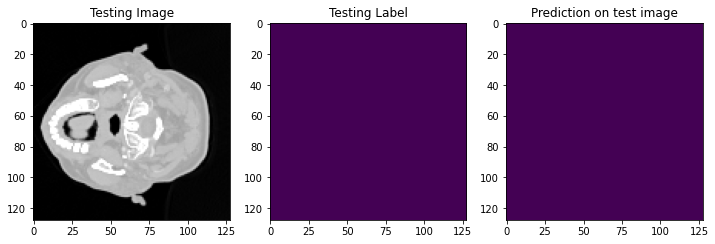

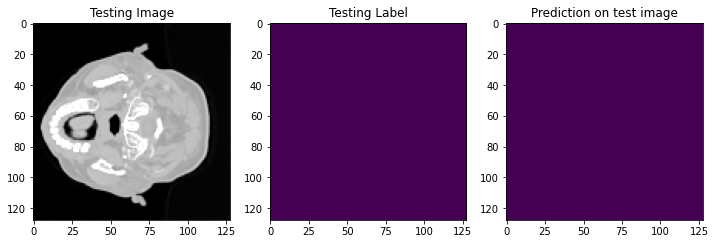

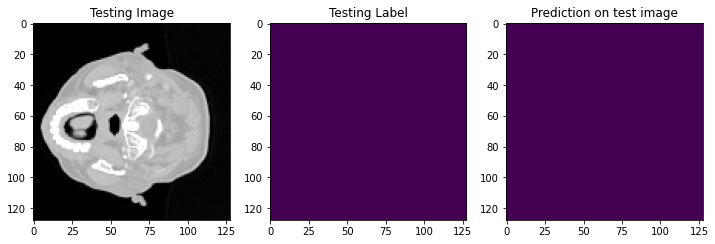

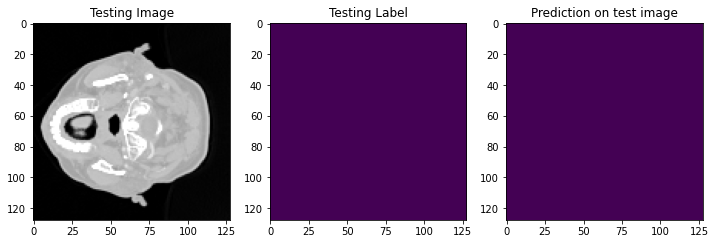

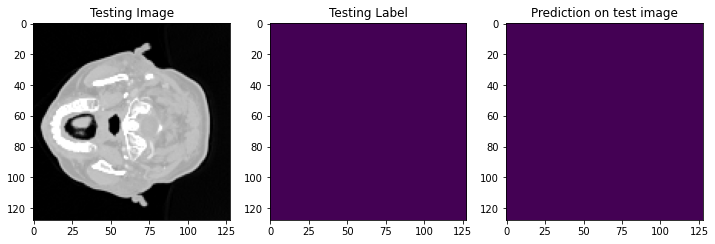

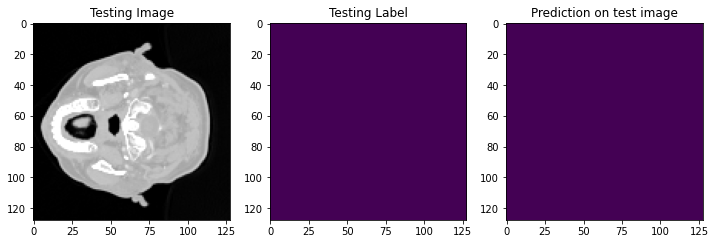

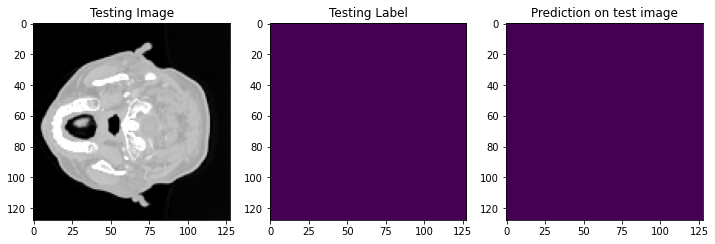

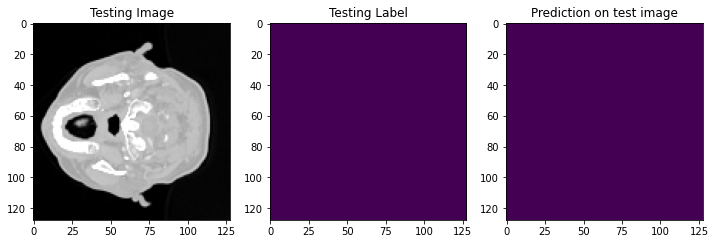

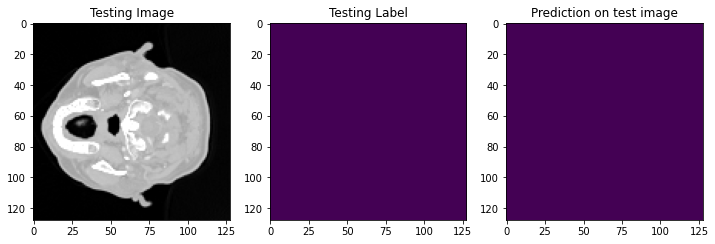

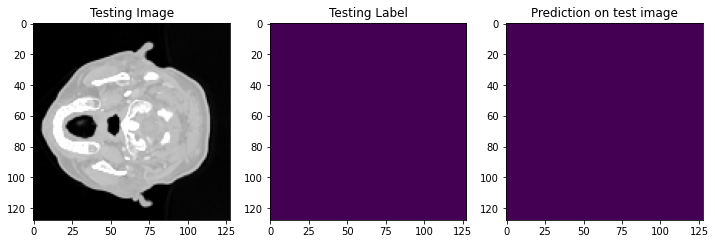

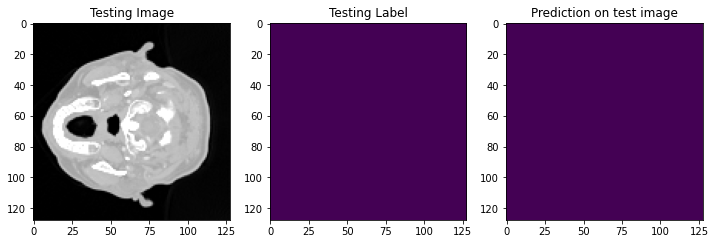

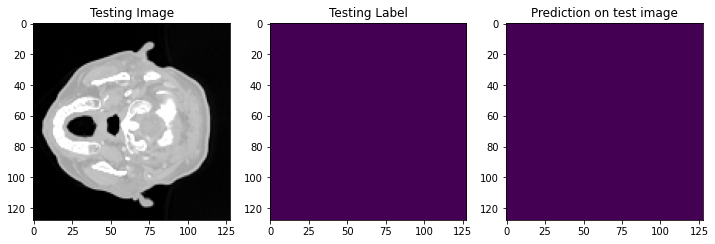

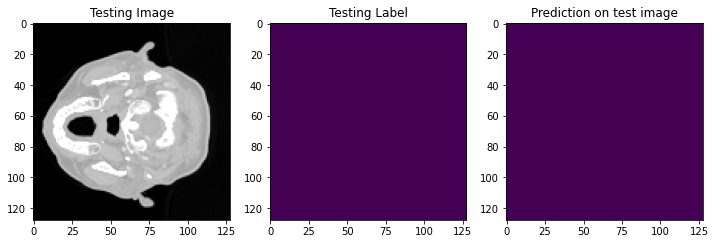

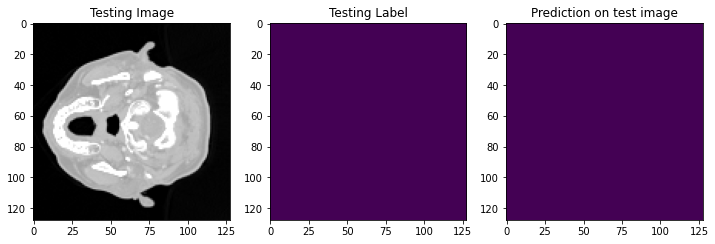

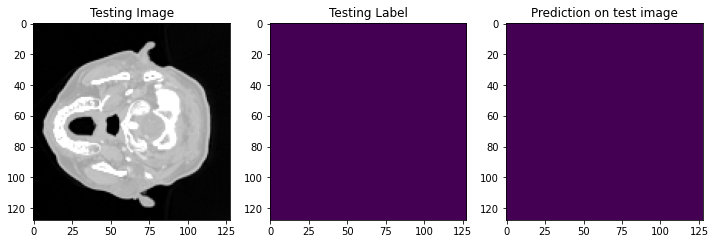

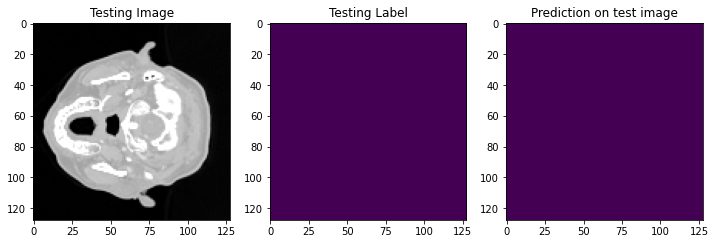

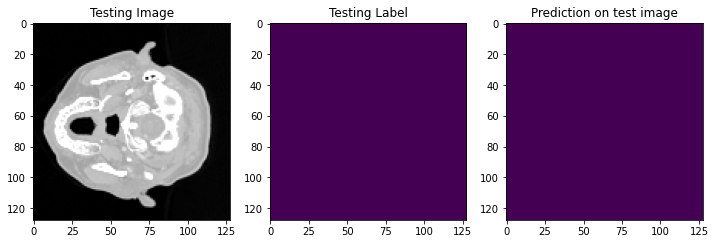

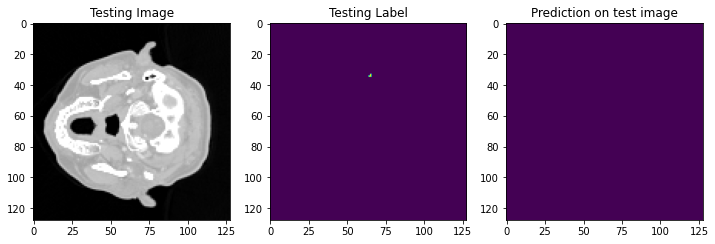

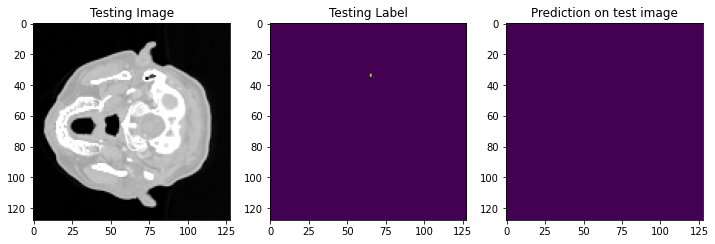

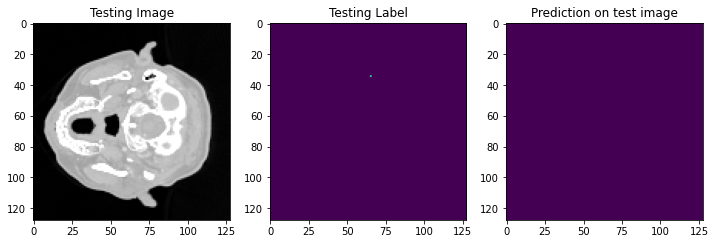

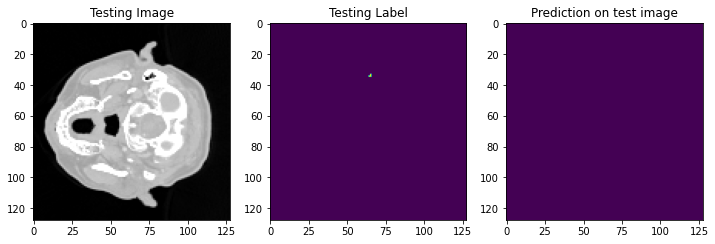

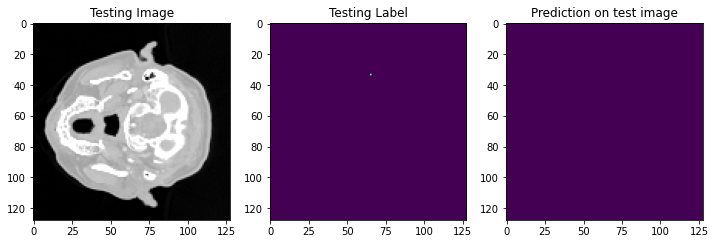

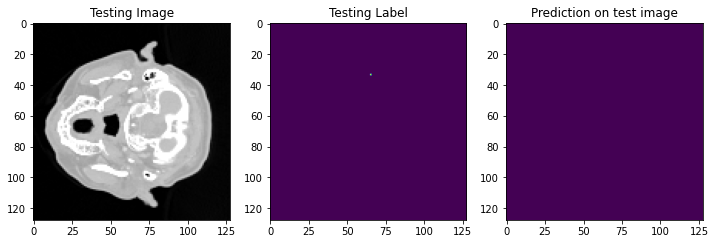

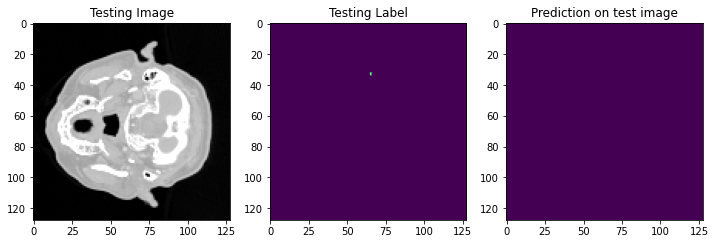

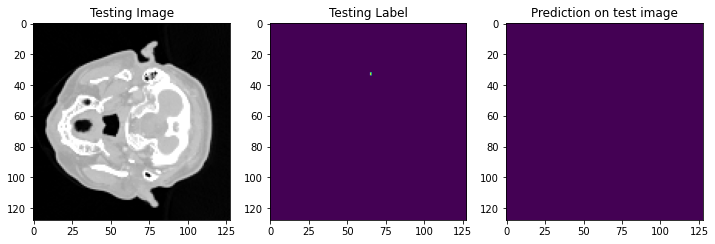

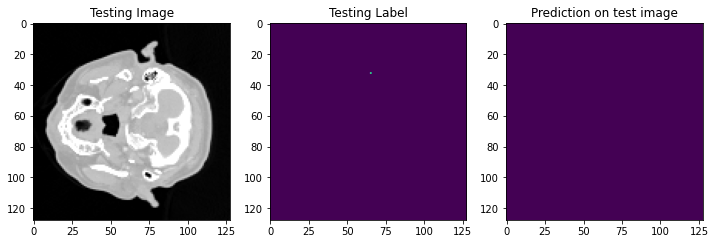

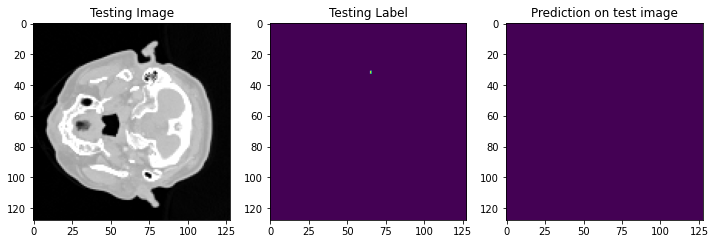

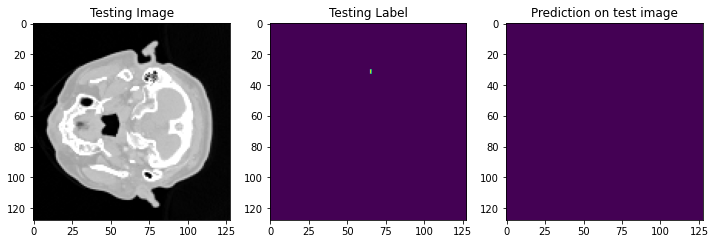

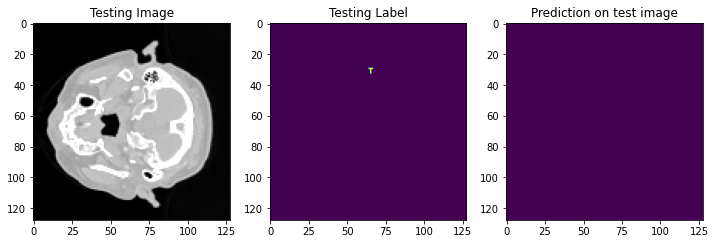

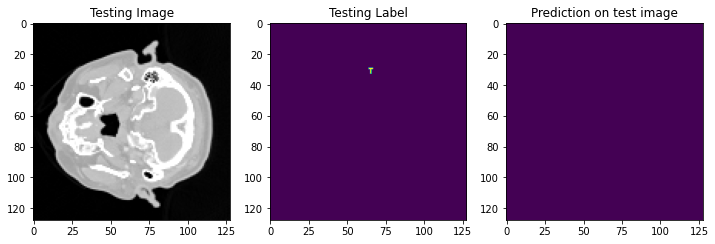

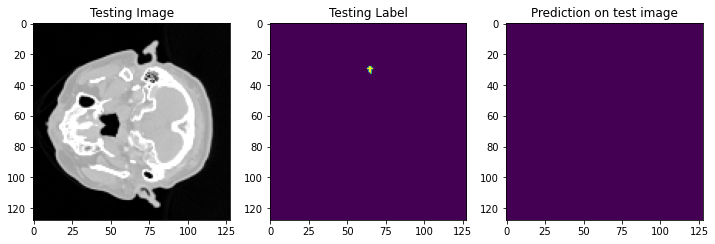

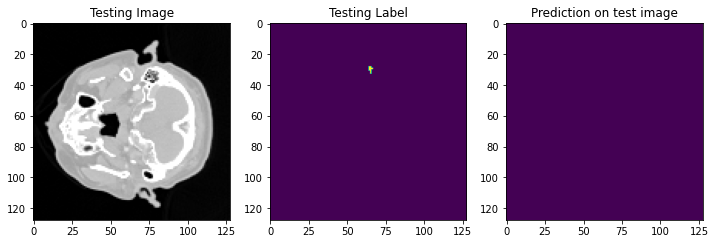

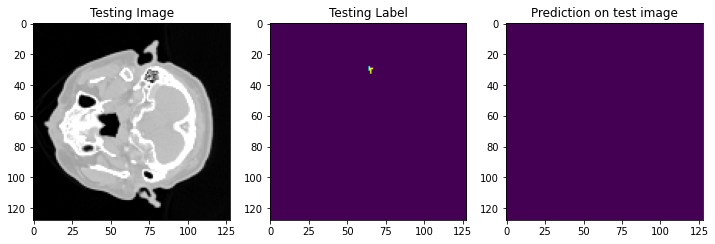

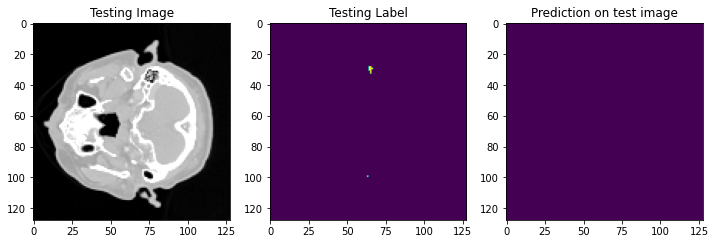

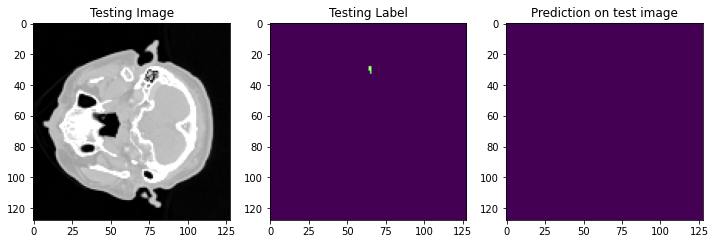

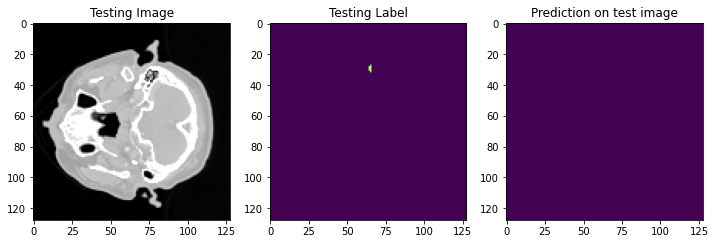

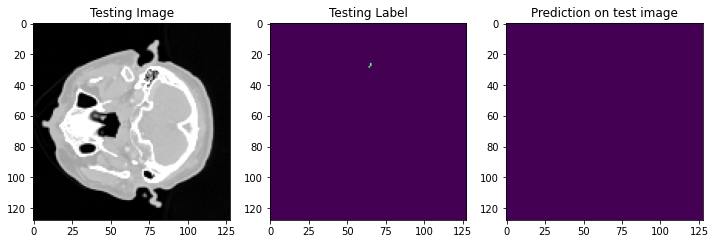

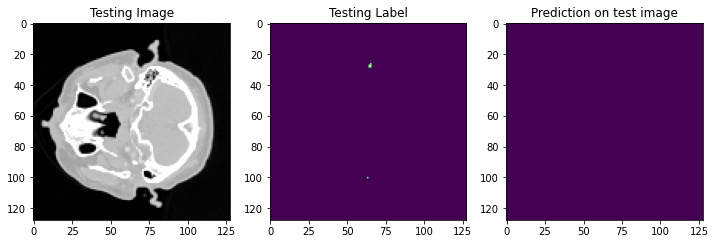

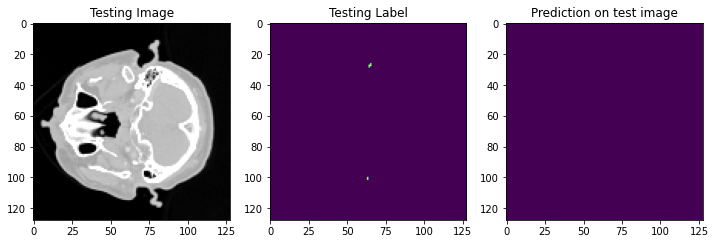

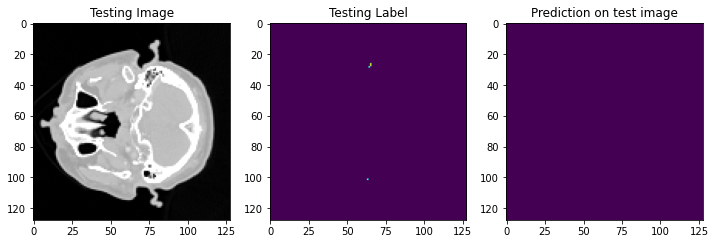

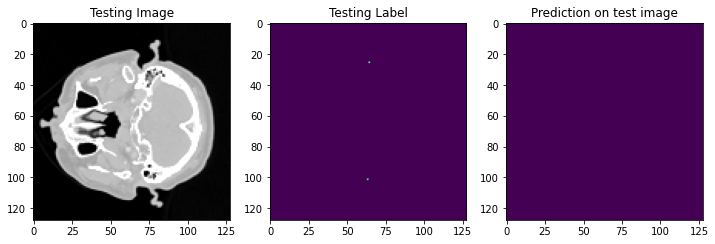

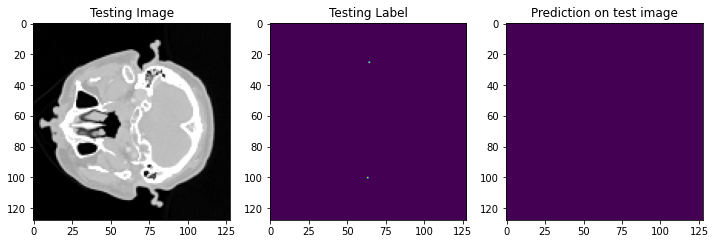

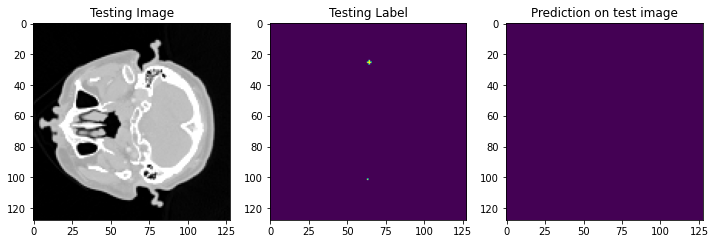

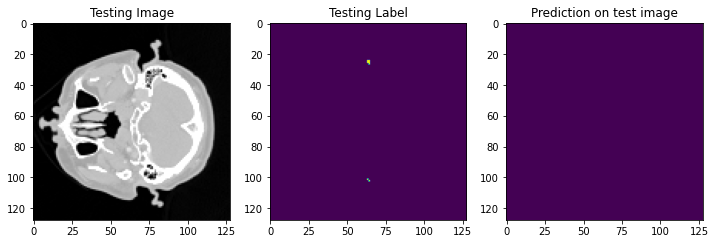

In [205]:
#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
for i in range(64):
    n_slice = i
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,n_slice], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(test_mask[:,:,n_slice])
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_prediction_argmax[:,:, n_slice])
    plt.show()